# Handwritten Digit Recognition using FCFNN
## Task: 
1. **Dataset Preparation:**

   * Collect English handwritten digit samples (0–9) from multiple individuals.
   * Preprocess the images (grayscale, resize to 28×28 pixels, normalize).
   * Split the dataset into a **training set** and a **test set**.
   * Save the dataset in a convenient format (e.g., `.npz`).

2. **Model Training:**

   * Define a **Fully Connected Feedforward Neural Network (FCFNN)**.
   * Retrain the FCFNN using **both your handwritten training set and the MNIST training set**.

3. **Model Evaluation:**

   * Evaluate the trained FCFNN on your **handwritten test set**.
   * Evaluate the trained FCFNN on the **MNIST test set**.
   * Compare the performance on both datasets.

---


##  Collect handwritten digit dataset

1. Take blank sheets and ask (friends/classmates) to write digits **0–9** multiple times (e.g., 20–30 samples each).
2. Scan or photograph the sheets.
3. Preprocess:

   * Convert to grayscale.
   * Apply thresholding (binarization).
   * Resize each digit to **28×28 pixels** (to match MNIST).
   * Normalize pixel values between **0 and 1**.

👉 Saving PNG files inside folders like:

```
custom_dataset/
  train/
    0/
    1/
    ...
    9/
  test/
    0/
    1/
    ...
    9/
```

## Making 28*28 png images from collect data

In [3]:
import cv2
import numpy as np
from PIL import Image
import os
import zipfile

# ========= CONFIG =========
INPUT_IMAGE = "digits_sheet.JPG"   # <-- replace with your file name
OUTPUT_DIR = "digits_28x28"
ZIP_NAME = "digits_28x28.zip"
# ==========================

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load image in grayscale
img = cv2.imread(INPUT_IMAGE, cv2.IMREAD_GRAYSCALE)

# Threshold (black digits on white background)
_, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours (digits)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours row by row, left to right
contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1]//50, cv2.boundingRect(c)[0]))

idx = 0
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    
    # Skip tiny noise
    if w < 5 or h < 5:
        continue
    
    digit = thresh[y:y+h, x:x+w]

    # Resize digit to 20x20
    digit_resized = cv2.resize(digit, (20, 20), interpolation=cv2.INTER_AREA)
    
    # Pad to 28x28
    padded = np.pad(digit_resized, ((4,4),(4,4)), "constant", constant_values=0)
    
    # Save each digit
    out_path = os.path.join(OUTPUT_DIR, f"digit_{idx:03d}.png")
    Image.fromarray(padded).save(out_path)
    idx += 1

# Create ZIP file
with zipfile.ZipFile(ZIP_NAME, 'w') as zipf:
    for file in os.listdir(OUTPUT_DIR):
        zipf.write(os.path.join(OUTPUT_DIR, file), file)

print(f"✅ Done! Extracted {idx} digits into {OUTPUT_DIR} and zipped into {ZIP_NAME}")


✅ Done! Extracted 121 digits into digits_28x28 and zipped into digits_28x28.zip


In [4]:
# Download mnist.npz dataset

! wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz


--2025-09-06 20:30:19--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.223.219, 142.250.193.59, 142.250.194.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.223.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11490434 (11M) [application/octet-stream]
Saving to: ‘mnist.npz.2’

mnist.npz.2         100%[===================>]  10.96M   955KB/s    in 20s     

2025-09-06 20:30:38 (554 KB/s) - ‘mnist.npz.2’ saved [11490434/11490434]



## Making custom_digits.npz dataset from (mnist.npz+handwritten image)
Ah! You want to **Create a new `.npz` dataset** that combines MNIST (`mnist.npz`) with  own **handwritten images**.

---
* Each image should have a **label** (0–9).
* Images can be in a folder structure like:

```
custom_digits/
   0/
     img1.png
     img2.png
   1/
     ...
```



---

### 3️⃣ Notes

1. **Image format**: The handwritten images are resized to **28×28** and converted to grayscale.
2. **Labels**: Folder names must be numeric (0–9).
3. **Saving**: Using `np.savez_compressed` to reduce file size.
4. **Result**: `custom_mnist.npz`

```

In [10]:
import numpy as np
import os
from PIL import Image

# Load MNIST
mnist = np.load("mnist.npz")
x_train_mnist, y_train_mnist = mnist["x_train"], mnist["y_train"]
x_test_mnist, y_test_mnist = mnist["x_test"], mnist["y_test"]
print("Mnist.npz loaded!")
print("Train set:", x_train.shape)
print("Test set:", x_test.shape)

# Function to load images from a folder structure like train/0, train/1, ..., test/0, etc.
def load_images_from_folder(base_dir):
    images, labels = [], []
    for label in sorted(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for file in os.listdir(label_dir):
            if file.endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(label_dir, file)
                img = Image.open(img_path).convert("L")  # grayscale
                img = img.resize((28,28))  # match MNIST size
                img_array = np.array(img, dtype=np.uint8)
                images.append(img_array)
                labels.append(int(label))
    return np.array(images, dtype=np.uint8), np.array(labels, dtype=np.uint8)

# Load custom train images
custom_train_dir = "custom_dataset/train"
x_train_custom, y_train_custom = load_images_from_folder(custom_train_dir)

# Load custom test images
custom_test_dir = "custom_dataset/test"
x_test_custom, y_test_custom = load_images_from_folder(custom_test_dir)

# Combine MNIST and custom images
x_train_combined = np.concatenate([x_train_mnist, x_train_custom], axis=0)
y_train_combined = np.concatenate([y_train_mnist, y_train_custom], axis=0)
x_test_combined = np.concatenate([x_test_mnist, x_test_custom], axis=0)
y_test_combined = np.concatenate([y_test_mnist, y_test_custom], axis=0)

# Save as new npz
np.savez_compressed(
    "custom_mnist.npz",
    x_train=x_train_combined,
    y_train=y_train_combined,
    x_test=x_test_combined,
    y_test=y_test_combined
)

print("✅ After Combining custom_mnist.npz created!")
print("Train set:", x_train_combined.shape)
print("Test set:", x_test_combined.shape)


Mnist.npz loaded!
Train set: (60000, 28, 28)
Test set: (10000, 28, 28)
✅ After Combining custom_mnist.npz created!
Train set: (61484, 28, 28)
Test set: (12405, 28, 28)


## Import Section

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder

2025-09-06 20:35:24.237949: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 20:35:24.931408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-06 20:35:27.887714: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Load Dataset

In [12]:
data    = np.load("custom_mnist.npz")
X_train = data['x_train']
X_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']
print( X_train.shape) 

(61484, 28, 28)


## FCFNN Neural Network Design



In [16]:
inputs = Input((28,28))
x = Flatten()(inputs)
x1 = Dense(128, activation="relu")(x)
x2 = Dense(256, activation="relu")(x1)
x3 = Dense(128,  activation="relu")(x2)
x4 = Dense(64,  activation="relu")(x3)
x5 = Dense(32,  activation="relu")(x4)
outputs = Dense(10, activation="softmax")(x5)
model = Model(inputs, outputs)

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,066 (691.66 KB)

 Trainable params: 177,066 (691.66 KB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

In [18]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## Model fitting

In [21]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9819 - loss: 0.0707 - val_accuracy: 0.8896 - val_loss: 0.4845
Epoch 2/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9851 - loss: 0.0531 - val_accuracy: 0.8900 - val_loss: 0.4887
Epoch 3/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9869 - loss: 0.0486 - val_accuracy: 0.8942 - val_loss: 0.4784
Epoch 4/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9874 - loss: 0.0448 - val_accuracy: 0.8932 - val_loss: 0.4632
Epoch 5/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9867 - loss: 0.0463 - val_accuracy: 0.8949 - val_loss: 0.5455
Epoch 6/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9881 - loss: 0.0462 - val_accuracy: 0.8843 - val_loss: 0.5902
Epoch 7/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9875 - loss: 0.0463 - val_accuracy: 0.8932 - val_loss: 0.7243
Epoch 8/20
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9885 - loss: 0.0431 

## Plot the training and validation accuracy


✅ Test Accuracy: 0.8894


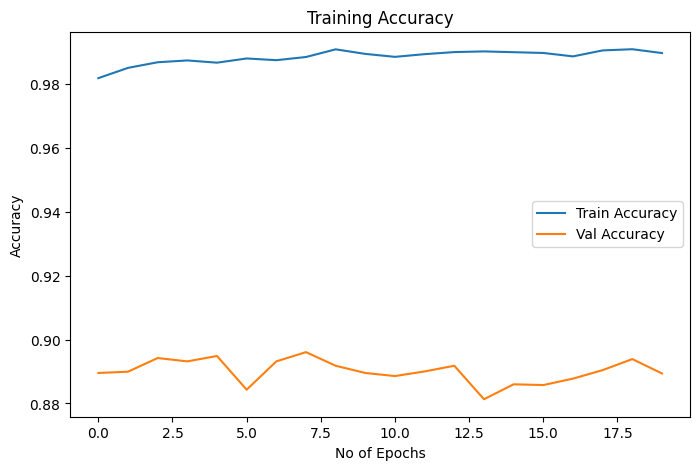

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

## Predict and plot the image with label


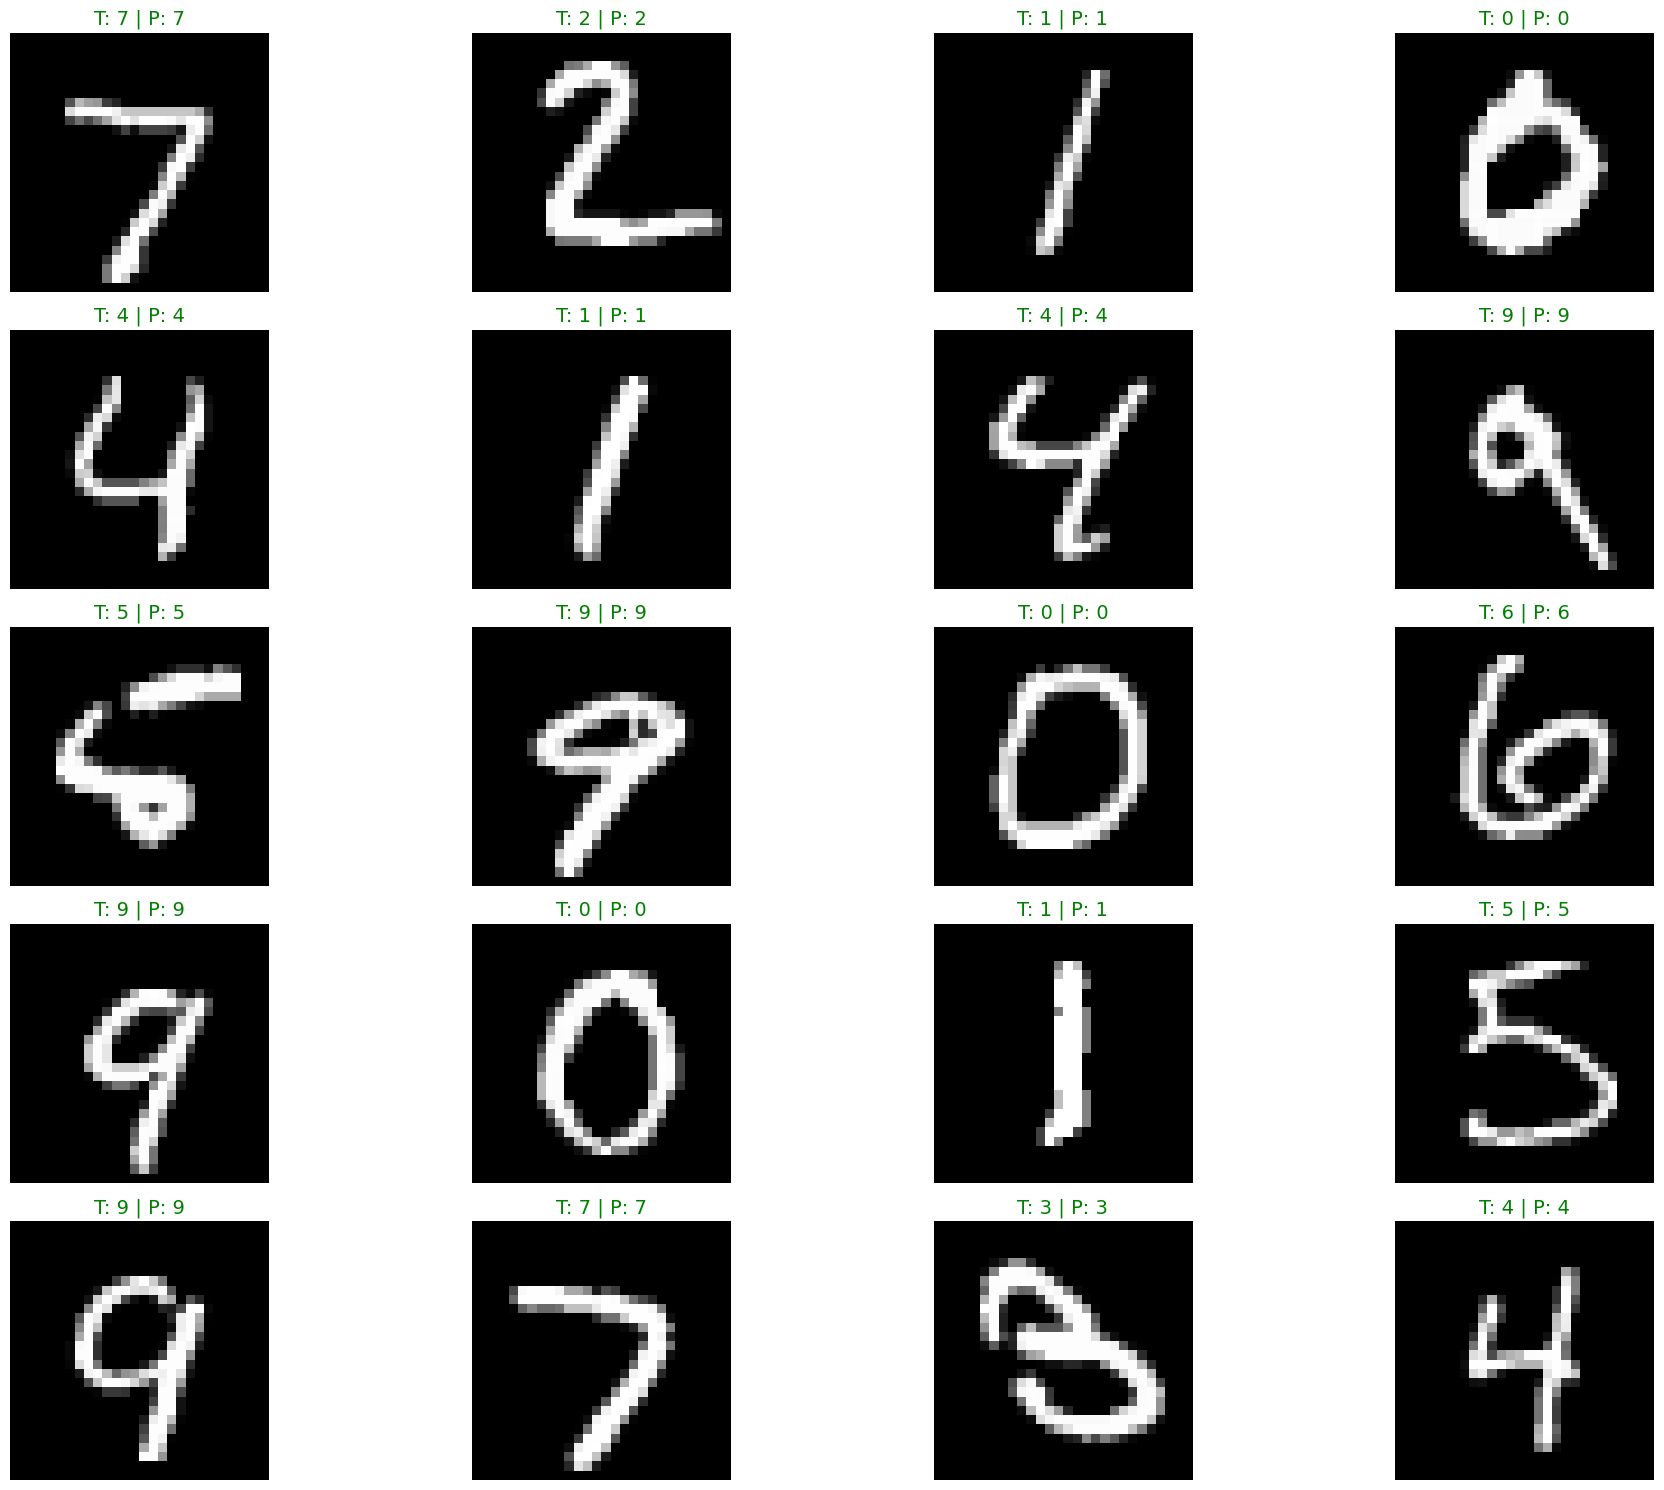

In [ ]:

plt.figure(figsize=(20,15))
n_show = min(20, len(X_test))  # show up to 20 images
rows, cols = 5, 4

for i in range(n_show):
    plt.subplot(rows, cols, i+1)
    
    # Prepare the image for prediction
    sample = X_test[i].reshape(1, 28, 28, 1)
    
    # Predict label
    pred = model.predict(sample, verbose=0).argmax(axis=1)[0]
    true_label = y_test[i]  # actual label
    
    # Set title with True vs Predicted
    plt.title(f"T: {true_label} | P: {pred}", fontsize=14, color=("green" if pred==true_label else "red"))
    
    # Show image
    plt.imshow(X_test[i], cmap="gray")
    plt.axis('off')

plt.tight_layout()
plt.show()